In [1]:
'''
Now we try to see if we can find more affordable players with statistica comparable to the winners of the league
'''

In [2]:
#1. We load data of the winners, the whole dataset and the important variables

import pandas as pd
import numpy as np

winners = pd.read_csv("Winners/1_league_winners_ref.csv")
players = pd.read_csv("../01_Datasets/Players Statistics/data_2/Final Datasets/Parametrized/Final_df_players_Parametrized.csv")
keepers = pd.read_csv("../01_Datasets/Players Statistics/data_2/Final Datasets/Parametrized/Final_df_keepers_Parametrized.csv")
variables_per_role = open("../02_Machine Learning/Variables per role.txt",'r')

In [3]:
new_roles = ['Centre-Back', 'Full-Back', 'Midfielder', 'Striker', 'Winger']

role_dictionary = {'Attacking Midfield' : new_roles[2], 
                   'Central Midfield' : new_roles[2], 
                   'Centre-Back' : new_roles[0],
                   'Centre-Forward' : new_roles[3],
                   'Defensive Midfield' : new_roles[2], 
                   'Left Midfield' : new_roles[4],
                   'Left Winger' : new_roles[4], 
                   'Left-Back' : new_roles[1],  
                   'Right Midfield' : new_roles[4], 
                   'Right Winger' : new_roles[4],
                   'Right-Back' : new_roles[1], 
                   'Second Striker' : new_roles[3]}

players['Gen_Pos'] = players['Position'].map(role_dictionary)
keepers['Gen_Pos'] = keepers['Position']
players = players.drop(['Position'], axis = 1)
keepers = keepers.drop(['Position'], axis = 1)

In [4]:
contents = variables_per_role.read()
print(contents)

Variables per role
Keepers, Goals.Against, Saves, Save., PSxG.SoT, PSxG.GA, Clean.Sheet.Percentage, Penalty.Kicks.Attempted, PSxG
Centre-Backs, Shots.on.target, Pass.Completion....Medium., Pass.Completion....Long., Passes.Attempted..Head., Successful.Pressure.., Touches..Def.Pen., Touches..Att.Pen., Passes.Received.., Ball.Recoveries, Aerials.won, Aerials.lost, X..of.Aerials.Won
Full-Backs, npxG, Pass.Completion.., Passes.Completed..Short., Pass.Completion....Short., Pass.Completion....Medium., Pass.Completion....Long., Touches..Att.Pen., Passes.Received.., Ball.Recoveries
Midfielders, Non.Penalty.Goals, npxG, Shots.on.target.., Pass.Completion.., Pass.Completion....Short., Pass.Completion....Medium., GCA..PassLive., Successful.Pressure.., Touches..Att.Pen., Passes.Received..
Wingers, Goals, Non.Penalty.Goals, xG, npxG, npxG.xA, Shots.Total, Shots.on.target, Shots.on.target.., Goals.Shot, Pass.Completion.., Pass.Completion....Short., Pass.Completion....Medium., Goal.Creating.Actions, G

In [5]:
dictionary_of_vars = {
    'Goalkeeper' : ['Goals.Against', 'Saves', 'Save.', 'PSxG.SoT', 'PSxG.GA', 
                    'Clean.Sheet.Percentage', 'Penalty.Kicks.Attempted', 'PSxG'],
    'Centre-Back' : ['Shots.on.target', 'Pass.Completion....Medium.', 'Pass.Completion....Long.', 'Passes.Attempted..Head.',
                     'Successful.Pressure..', 'Touches..Def.Pen.', 'Touches..Att.Pen.', 'Passes.Received..', 'Ball.Recoveries',
                     'Aerials.won', 'Aerials.lost', 'X..of.Aerials.Won'],
    'Full-Back' : ['npxG', 'Pass.Completion..', 'Passes.Completed..Short.', 'Pass.Completion....Short.', 
                   'Pass.Completion....Medium.', 'Pass.Completion....Long.', 'Touches..Att.Pen.', 'Passes.Received..', 
                   'Ball.Recoveries'], 
    'Midfielder' : ['Non.Penalty.Goals', 'npxG', 'Shots.on.target..', 'Pass.Completion..', 'Pass.Completion....Short.',
                    'Pass.Completion....Medium.', 'GCA..PassLive.', 'Successful.Pressure..', 'Touches..Att.Pen.',
                    'Passes.Received..'],
    'Striker' : ['Goals', 'Assists', 'Non.Penalty.Goals', 'xG', 'npxG', 'npxG.xA', 'Shots.Total', 'Shots.on.target',
                 'Shots.on.target..', 'Goals.Shot', 'Pass.Completion..', 'Pass.Completion....Short.', 
                 'Pass.Completion....Medium.', 'GCA..PassLive.', 'Successful.Pressure..', 'Touches..Att.Pen.', 'Pass.Targets',
                 'Fouls.Committed'],
    'Winger' : ['Goals', 'Non.Penalty.Goals', 'xG', 'npxG', 'npxG.xA', 'Shots.Total', 'Shots.on.target', 'Shots.on.target..', 
                'Goals.Shot','Pass.Completion..', 'Pass.Completion....Short.', 'Pass.Completion....Medium.',
                'Goal.Creating.Actions', 'GCA..PassLive.', 'Touches..Att.Pen.']
}

In [6]:
#3. Let's try to build a function which will output the low-cost players

def low_cost_winners(season, league, save_on_the_budget):
    
    winners_league_year = winners[(winners['League'] == league) & (winners['Season'] == season)]
    substitutes = []
    
    for i in range(len(list(dictionary_of_vars.keys()))):
        
        players_ref = pd.DataFrame()
        keepers_ref = pd.DataFrame()
        pla = pd.DataFrame()
        tot = pd.DataFrame()
    
        if list(dictionary_of_vars.keys())[i] == "Goalkeeper":
        
            keepers_ref = keepers[['Player_SN', 'scouting_period', 'Data_League', 'Gen_Pos', 'Player Valuation'] + dictionary_of_vars[list(dictionary_of_vars.keys())[i]]]
            keepers_ref = keepers_ref[(keepers_ref['scouting_period'] == season)]#&(keepers_ref['Data_League'] == league)]
            
            pla = winners_league_year[winners_league_year['Gen_Pos'] == list(dictionary_of_vars.keys())[i]]
            
            tot = pd.merge(keepers_ref, pla, left_on = ['Player_SN', 'Data_League', 'scouting_period', 'Gen_Pos'],
               right_on = ['Player','League','Season','Gen_Pos']).drop(['Player','League','Season'], axis = 1)
            tot2 = tot.drop("Player Valuation", axis = 1)
            important_values = tot2.mean(numeric_only=True)
            
            diff_df = keepers_ref[dictionary_of_vars[list(dictionary_of_vars.keys())[i]]] - tot2.mean(numeric_only=True).values
            norm_df = diff_df.apply(np.linalg.norm, axis=1)
            norm_df = pd.DataFrame(norm_df[norm_df!=0])
            norm_df.columns = ['Similarity']
            
            sim_df = norm_df.join(keepers_ref[['Player_SN','Player Valuation', 'Gen_Pos'] + dictionary_of_vars[list(dictionary_of_vars.keys())[i]]][(keepers_ref['Player Valuation'] <= (np.mean(tot['Player Valuation'])/save_on_the_budget))&(keepers_ref['Gen_Pos'] == np.unique(tot['Gen_Pos'])[0])]).dropna()
            #sim_df = sim_df[~sim_df['Player_SN'].isin(tot['Player_SN'])].dropna()
            for pp in sim_df.sort_values(by = ['Similarity'], ascending = True)[:len(tot)][['Similarity','Player_SN','Player Valuation', 'Gen_Pos']].values.tolist():
                substitutes.append(pp)
        
        else:
        
            players_ref = players[['Player_SN', 'scouting_period', 'Data_League', 'Gen_Pos', 'Player Valuation'] + dictionary_of_vars[list(dictionary_of_vars.keys())[i]]]
            players_ref = players_ref[(players_ref['scouting_period'] == season)]#&(players_ref['Data_League'] == league)]
            
            pla = winners_league_year[winners_league_year['Gen_Pos'] == list(dictionary_of_vars.keys())[i]]
            
            tot = pd.merge(players_ref, pla, left_on = ['Player_SN', 'Data_League', 'scouting_period', 'Gen_Pos'],
               right_on = ['Player','League','Season','Gen_Pos']).drop(['Player','League','Season'], axis = 1)
            tot2 = tot.drop("Player Valuation", axis = 1)
            important_values = tot2.mean(numeric_only=True)
            
            diff_df = players_ref[dictionary_of_vars[list(dictionary_of_vars.keys())[i]]] - tot2.mean(numeric_only=True).values
            norm_df = diff_df.apply(np.linalg.norm, axis=1)
            norm_df = pd.DataFrame(norm_df[norm_df!=0])
            norm_df.columns = ['Similarity']
            
            sim_df = norm_df.join(players_ref[['Player_SN','Player Valuation', 'Gen_Pos'] + dictionary_of_vars[list(dictionary_of_vars.keys())[i]]][(players_ref['Player Valuation'] <= (np.mean(tot['Player Valuation'])/save_on_the_budget))&(players_ref['Gen_Pos'] == np.unique(tot['Gen_Pos'])[0])]).dropna()
            #sim_df = sim_df[~sim_df['Player_SN'].isin(tot['Player_SN'])].dropna()
            for pp in sim_df.sort_values(by = ['Similarity'], ascending = True)[:len(tot)][['Similarity','Player_SN','Player Valuation', 'Gen_Pos']].values.tolist():
                substitutes.append(pp)
    
    datasim = pd.DataFrame(substitutes)
    datasim.columns = ['Similarity', 'Player', 'Player Valuation', 'Position']
    
    return datasim

In [22]:
# Let's check which league has the best trade off between savings and similarity coefficient

seasons = ['2017-2018','2018-2019','2019-2020','2020-2021']
leagues = ['Premier League','Serie A','Ligue 1','Bundesliga','La Liga']
total_players = pd.concat([players[['Player_SN', 'Data_League','scouting_period','Gen_Pos', 'Player Valuation']], 
                           keepers[['Player_SN', 'Data_League','scouting_period','Gen_Pos', 'Player Valuation']]],
                           ignore_index = True)

sim = []
for i in range(len(seasons)):
    for j in range(len(leagues)):
        
        winners_league_year = winners[(winners['League'] == leagues[j]) & (winners['Season'] == seasons[i])]
        
        tot = pd.merge(total_players, winners_league_year, left_on = ['Player_SN', 'Data_League', 'scouting_period', 'Gen_Pos'],
               right_on = ['Player','League','Season','Gen_Pos'])
        
        sim.append([seasons[i], 
                    leagues[j],
                    np.mean(low_cost_winners(seasons[i], leagues[j], 2)['Similarity']),
                    np.sum(tot['Player Valuation']) - np.sum(low_cost_winners(seasons[i], leagues[j], 2)['Player Valuation'])])
        
coeff = pd.DataFrame(sim)
coeff.columns = ['Season','League','Similarity Coeff.', 'Savings']
coeff['Trade Off'] = (coeff['Savings'] / coeff['Similarity Coeff.'])/10000000
coeff.sort_values(by = ['Trade Off'], ascending = False, inplace = True)
coeff = coeff.reset_index().drop(['index'], axis = 1)
coeff

,Season,League,Similarity Coeff.,Savings,Trade Off
0,2019-2020,Premier League,5.621322,801833332.0,14.264142
1,2018-2019,Ligue 1,5.763644,728016667.0,12.631188
2,2020-2021,Bundesliga,5.364341,648020832.0,12.080157
3,2019-2020,Ligue 1,6.021776,687675001.0,11.419804
4,2020-2021,Premier League,7.432623,786358335.0,10.579823
5,2019-2020,Bundesliga,5.533250,582424999.0,10.525912
6,2017-2018,Ligue 1,5.853028,614383333.0,10.496846
7,2018-2019,Serie A,4.960894,513016667.0,10.341214
8,2018-2019,La Liga,7.282616,744874999.0,10.228125
9,2020-2021,Serie A,4.424397,451216667.0,10.198375


In [9]:
low_cost_winners('2019-2020', 'Premier League', 2)

,Similarity,Player,Player Valuation,Position
0,1.073374,Rui Patrício,18000000.0,Goalkeeper
1,1.580452,Edouard Mendy,8000000.0,Goalkeeper
2,6.649027,Gabriel Paulista,19750000.0,Centre-Back
3,7.286307,Marc Bartra,19750000.0,Centre-Back
4,7.451461,Fikayo Tomori,15333333.0,Centre-Back
5,4.475290,César Azpilicueta,27000000.0,Full-Back
6,5.479542,Sergio Escudero,5400000.0,Full-Back
7,4.806333,Unai López,2700000.0,Midfielder
8,5.728225,Yves Bissouma,10750000.0,Midfielder
9,6.461457,Rafinha,10750000.0,Midfielder


In [10]:
from collections import Counter

ripetizioni = []

for i in range(len(seasons)):
    giocatori_della_season = []
    for j in range(len(leagues)):
        data = low_cost_winners(seasons[i], leagues[j], 2)
        giocatori_della_season.append([i for i in data['Player']])
    giocatori_della_season = [item for sublist in giocatori_della_season for item in sublist]
    giocatori_della_season = list(set(giocatori_della_season))
    ripetizioni.append(giocatori_della_season)
        
ripetizioni = [item for sublist in ripetizioni for item in sublist]

In [11]:
from collections import Counter, OrderedDict

x = Counter(ripetizioni)
y = OrderedDict(x.most_common())

y

OrderedDict([('Franck Ribéry', 3),
             ('Gerard Moreno', 3),
             ('Otávio', 3),
             ('Iago Aspas', 2),
             ('Nacho Monreal', 2),
             ('Timothy Castagne', 2),
             ('Andriy Yarmolenko', 2),
             ('Pierre Højbjerg', 2),
             ('Patrik Schick', 2),
             ('Karim Bellarabi', 2),
             ('Julian Baumgartlinger', 2),
             ('Bouna Sarr', 2),
             ('Juanmi', 2),
             ('Márcio Rafael Ferreira de Souza', 2),
             ('Vincent Kompany', 2),
             ("Nicolas N'Koulou", 2),
             ('Pione Sisto', 2),
             ('Łukasz Piszczek', 2),
             ('Christoph Kramer', 2),
             ('Christophe Jallet', 2),
             ('Antonio Barragán', 2),
             ('Willian José', 2),
             ('Gabriel Paulista', 2),
             ('Jason Denayer', 2),
             ('Rogério', 2),
             ('Remo Freuler', 2),
             ('Vincenzo Grifo', 2),
             ('Juan Foyth',

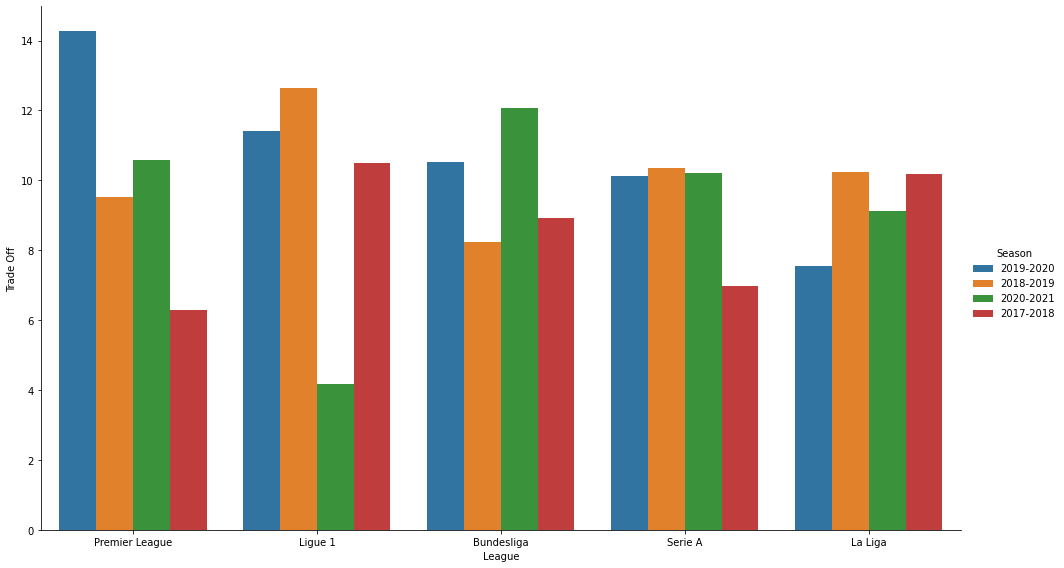

In [38]:
import seaborn as sns

g = sns.catplot(x="League", y="Trade Off",
                hue="Season",data=coeff, kind="bar",
                height=8, aspect=1.7)

g